## Feature Selection Methods: 
- Variance Threshold
- L1 Regularization (Lasso)
- Random Forest Feature Importance 
- Permutation Importance
    - with Random Forest
    - with Ridge Regression
- Recursive Feature Elimination (RFE)
    - with Random Forest
    - with Ridge Regression
- Sequential Feature Selection (SFS)
    - with KNN
    - with Ridge Regression

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings 
# warnings.filterwarnings("ignore")

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

In [3]:
df = pd.read_csv('../data/data_clean/SASS_cleaned_v2.csv', sep=',', header=0)
print(df.shape)

(3640, 57)


In [4]:
cols_ren = {'label_Current_Teacher': 'label_Current',
'vacnc_difficult_STEM_Yes': 'vacnc_STEM',
'number_of_dependents': 'num_dependents',
'region_Northeast': 'region_Northeast',
'region_West': 'region_West',
'marital_status_Married': 'married',
'race_t_White': 'race_T_White',
'race_t_Black': 'race_T_Black',
'race_t_Hispanic': 'race_T_Hispanic',
'gender_t_Female': 'gender_T_Female',
'summer_teaching_Yes': 'summer_teaching',
'nonteaching_job_Yes': 'nonteaching_job',
'nonschool_job_Yes': 'nonschool_job',
'extracur_act_Yes': 'extracur_act',
'merit_pay_Yes': 'merit_pay',
'union_member_Yes': 'union_member',
'BA_major_code_STEM': 'BA_major_STEM',
'MA_major_code_STEM': 'MA_major_STEM',
'main_tch_fields_cert_type_Regular': 'field_cert_Regular',
'MA_deg_Yes': 'deg_T_MA',
'pd_time': 'pd_time',
'pd_finance': 'pd_finance',
'remain_in_teaching': 'remain_teaching',
'STEM_teaching_field': 'field_STEM',
'STEM_hours_taught': 'hrs_taught_STEM',
'public_ft_exp': 'public_ft_exp',
'public_pt_exp': 'public_pt_exp',
'private_ft_exp': 'private_ft_exp',
'class_org': 'class_org',
'main_teaching_lastyr_Same_as_thisyr': 'field_same',
'ft_pt_status_FT': 'full_time',
'teaches_ungraded_Yes': 'teaches_ungraded',
'teaches_7_to_12': 'teaches_7to12',
'new_teacher_Yes': 'new_teacher',
'percent_minority_students': 'minority_students',
'FRPL_eligible_k_12_students': 'FRPL_eligible_k12',
'student_teacher_ratio': 'stu_tch_ratio',
'sch_type': 'sch_type',
'level_Elementary': 'level_Elementary',
'urbanicity': 'urbanicity',
'title_I_receive_students_Yes': 'title_I_receive',
'age_p': 'age_P',
'salary': 'salary_P',
'yrs_princpl_this_sch': 'yrs_P_this_sch',
'yrs_princpl_oth_schls': 'yrs_P_oth_schls',
'yrs_tchng_before_princpl': 'yrs_tch_before_P',
'yrs_tchng_since_princpl': 'yrs_tch_since_P',
'deg_highest_P': 'deg_highest_P',
'race_p_Black': 'race_P_Black',
'race_p_White': 'race_P_White',
'race_p_Hispanic': 'race_P_Hispanic',
'gender_p_Female': 'gender_P_Female',
'incentives_pay': 'incen_pay',
'incentives_recruit_NonSTEM': 'incen_NonSTEM'}
 
df.rename(columns=cols_ren, inplace=True)

In [5]:
df3 = pd.read_csv('../data/data_clean/SASS_cleaned_v3.csv', sep=',', header=0)
temp = [c for c in df.columns if c not in df3.columns]
temp

['class_org', 'teaches_ungraded']

**Split data**

In [6]:
label = ['label_Current']

cols_drop = ['CNTLNUM_T', 'SCHCNTL', 'CNTLNUM_P']

y = df[label].values.ravel()
X = df.drop(columns=label + cols_drop).values
columns = df.drop(columns=label + cols_drop).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=123, shuffle=True)
print(X.shape)

(3640, 53)


**Normalization**

In [7]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
random_state=123
results = pd.DataFrame()

### Variance Threshold ###

In [9]:
from sklearn.feature_selection import VarianceThreshold

# dropping columns where 1-threshold of the values are similar
# a feature contains only 0s 80% of the time or only 1s 80% of the time
sel = VarianceThreshold(threshold=.8*(1-.8))

sel.fit_transform(X)
selected_var = columns[sel.get_support()]

temp = pd.DataFrame({'feature': selected_var.to_list(),
                     'method': 'Variance Threshold',
                     'model': 'n/a',
                     'importance': 1})
results = pd.concat([results, temp], ignore_index=True)

print('n_features_selected:',selected_var.shape[0])
print('Features Selected: ', selected_var)

n_features_selected: 34
Features Selected:  Index(['vacnc_STEM', 'num_dependents', 'region_West', 'married',
       'gender_T_Female', 'nonschool_job', 'extracur_act', 'union_member',
       'deg_T_MA', 'pd_finance', 'remain_teaching', 'hrs_taught_STEM',
       'public_ft_exp', 'public_pt_exp', 'private_ft_exp', 'class_org',
       'teaches_7to12', 'new_teacher', 'minority_students',
       'FRPL_eligible_k12', 'stu_tch_ratio', 'sch_type', 'level_Elementary',
       'urbanicity', 'title_I_receive', 'age_P', 'salary_P', 'yrs_P_this_sch',
       'yrs_P_oth_schls', 'yrs_tch_before_P', 'yrs_tch_since_P',
       'deg_highest_P', 'gender_P_Female', 'incen_pay'],
      dtype='object')


### L1(Lasso) Regularization ###

In [10]:
from sklearn.linear_model import LogisticRegression

lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=random_state)
lasso.fit(X_train, y_train)

print('Train Accuracy: {:0.2f}'.format(lasso.score(X_train, y_train)))
print('Test Accuracy: {:0.2f}'.format(lasso.score(X_test, y_test)))

df_lasso = pd.DataFrame()

for c, cla in zip(lasso.coef_, range(-2,3,1)):
    temp = pd.DataFrame({'feature': columns, 'coef': c, 'class': cla})
    df_lasso = pd.concat([df_lasso, temp], ignore_index=True)

df_lasso2 = df_lasso.groupby(['feature'], as_index=False).agg({'coef': 'sum'})
df_lasso2['Model'] = 'Lasso'

df_lasso3 = df_lasso2[df_lasso2['coef']!=0].copy()
df_lasso3.loc[:,'importances'] = 1
temp = pd.DataFrame({'feature': df_lasso3['feature'], 
                        'method': 'Regularization',
                        'model': 'Lasso', 
                        'importance': df_lasso3['importances']})
results = pd.concat([results, temp], ignore_index=True)

Train Accuracy: 0.73
Test Accuracy: 0.75


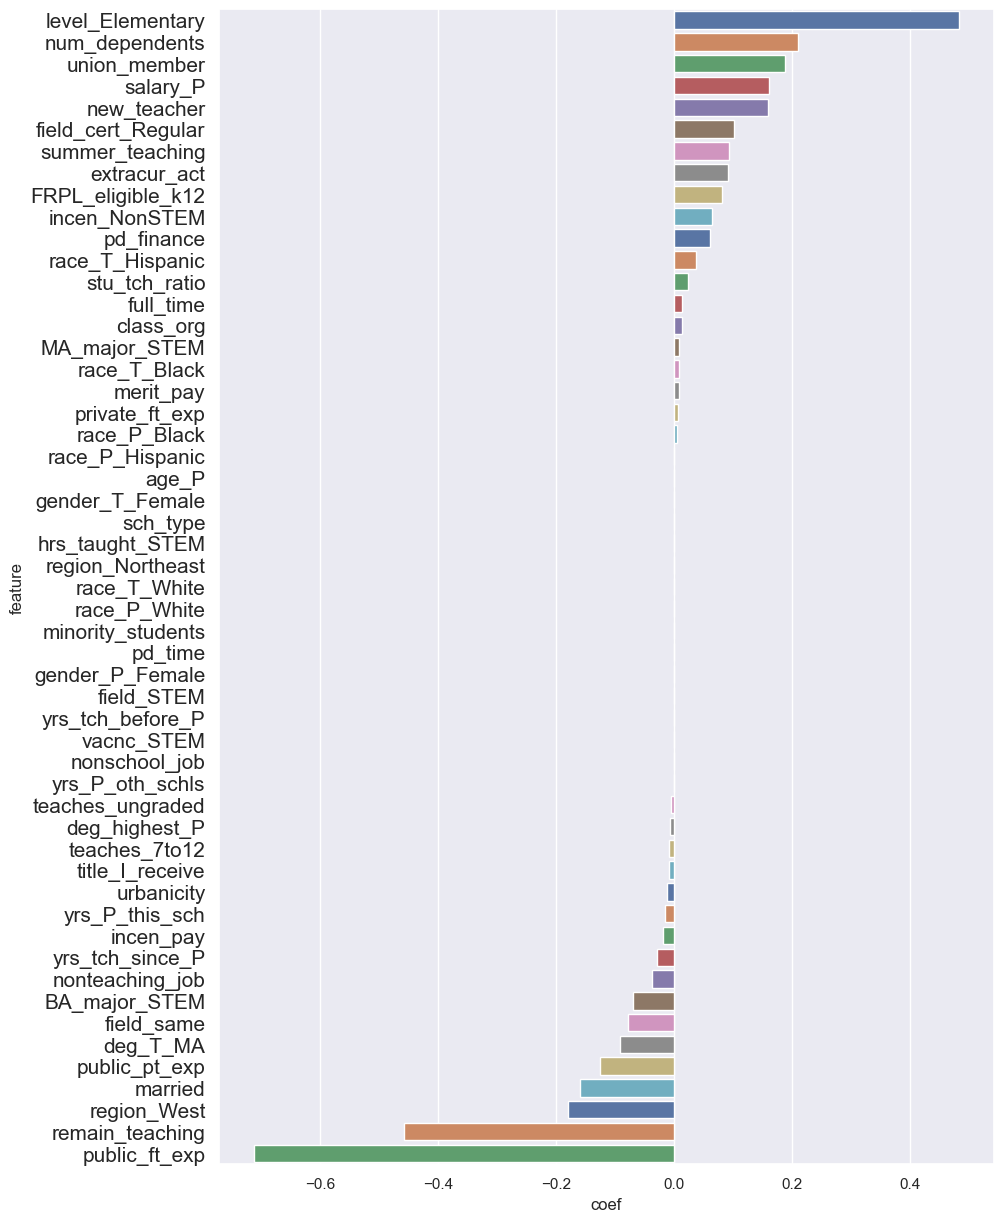

In [11]:
df_lasso2 = df_lasso2.sort_values(by=['coef'], ascending=False)
sns.set(rc={'figure.figsize':(10, 15)})
g=sns.barplot(data=df_lasso2, y="feature", x="coef", palette="deep", orient="h")
# g.set_xticklabels(g.get_xticklabels(), rotation=90, size=20)
g.set_yticklabels(g.get_yticklabels(), size=15)
plt.show()

### Random Forest Feature Importance ###

Train Score: 1.00
Test Score: 0.76


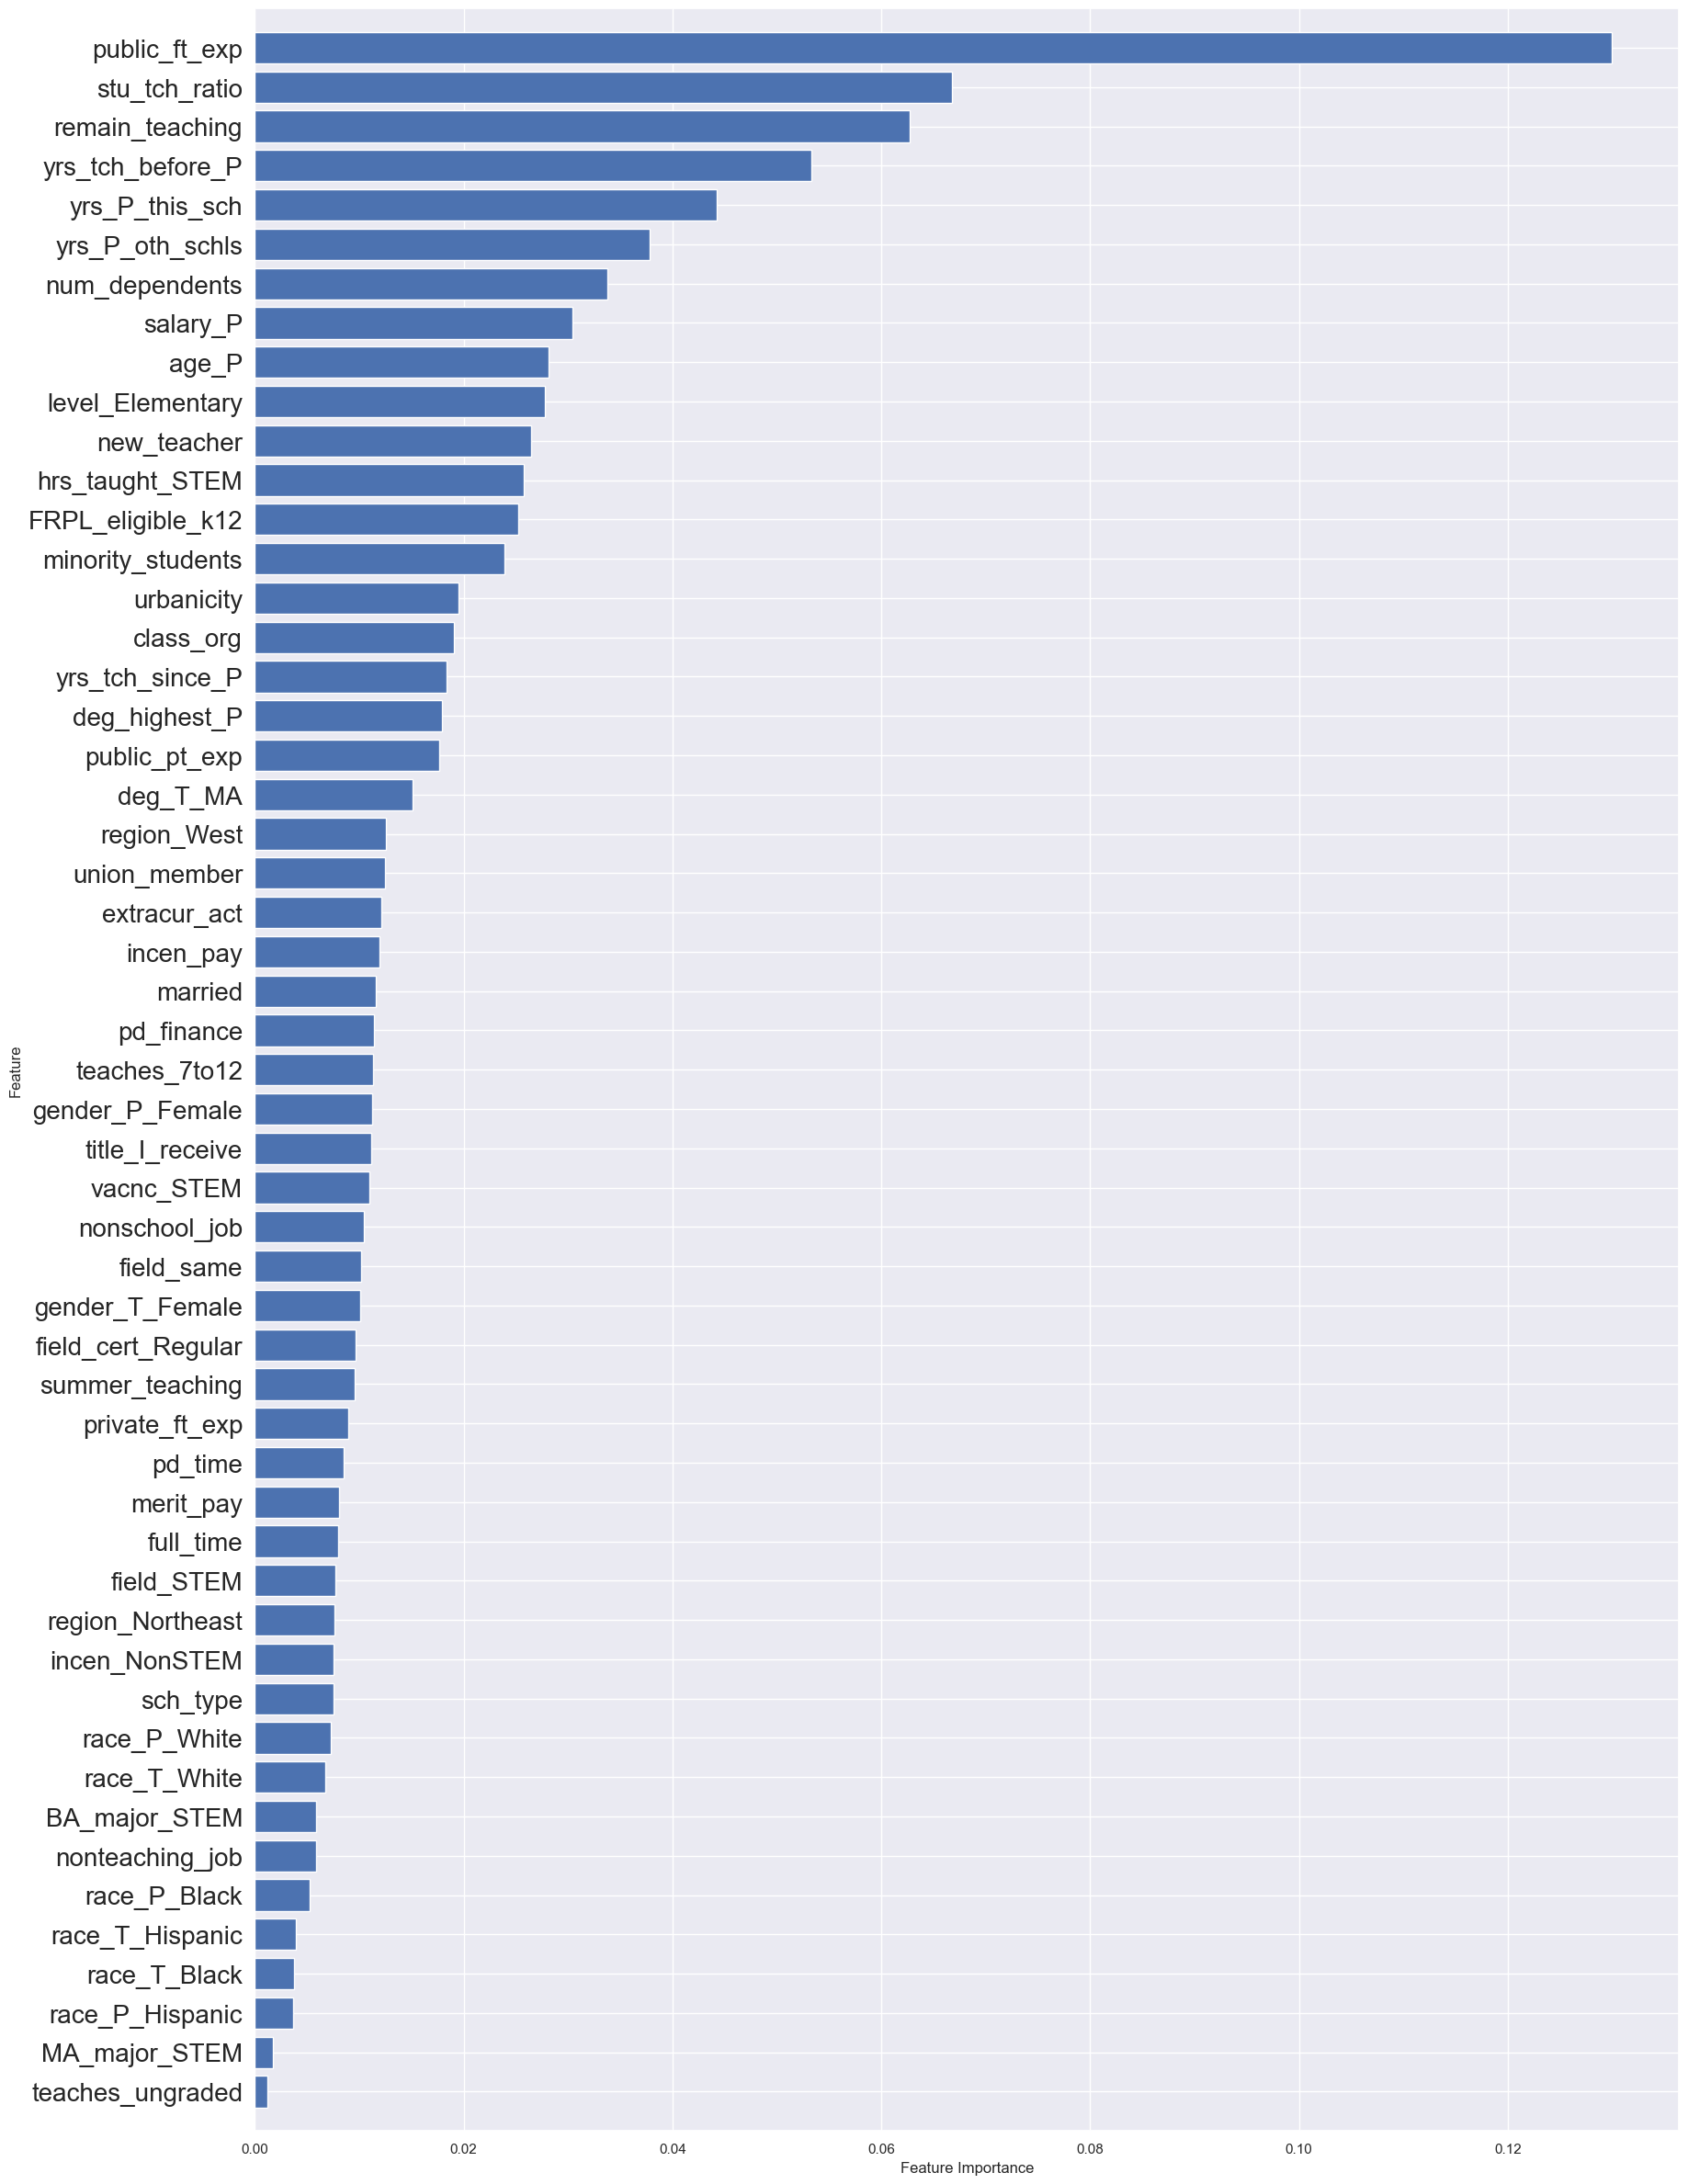

In [12]:
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20,30))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.barh(range(X_train.shape[1]), importances[indices], align='center')
plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.show()

temp = pd.DataFrame({'feature': columns, 
                        'method': 'Feature Importance',
                        'model': 'Random Forest', 
                        'importance': importances})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Random Forest

Train Score: 1.00
Test Score: 0.76


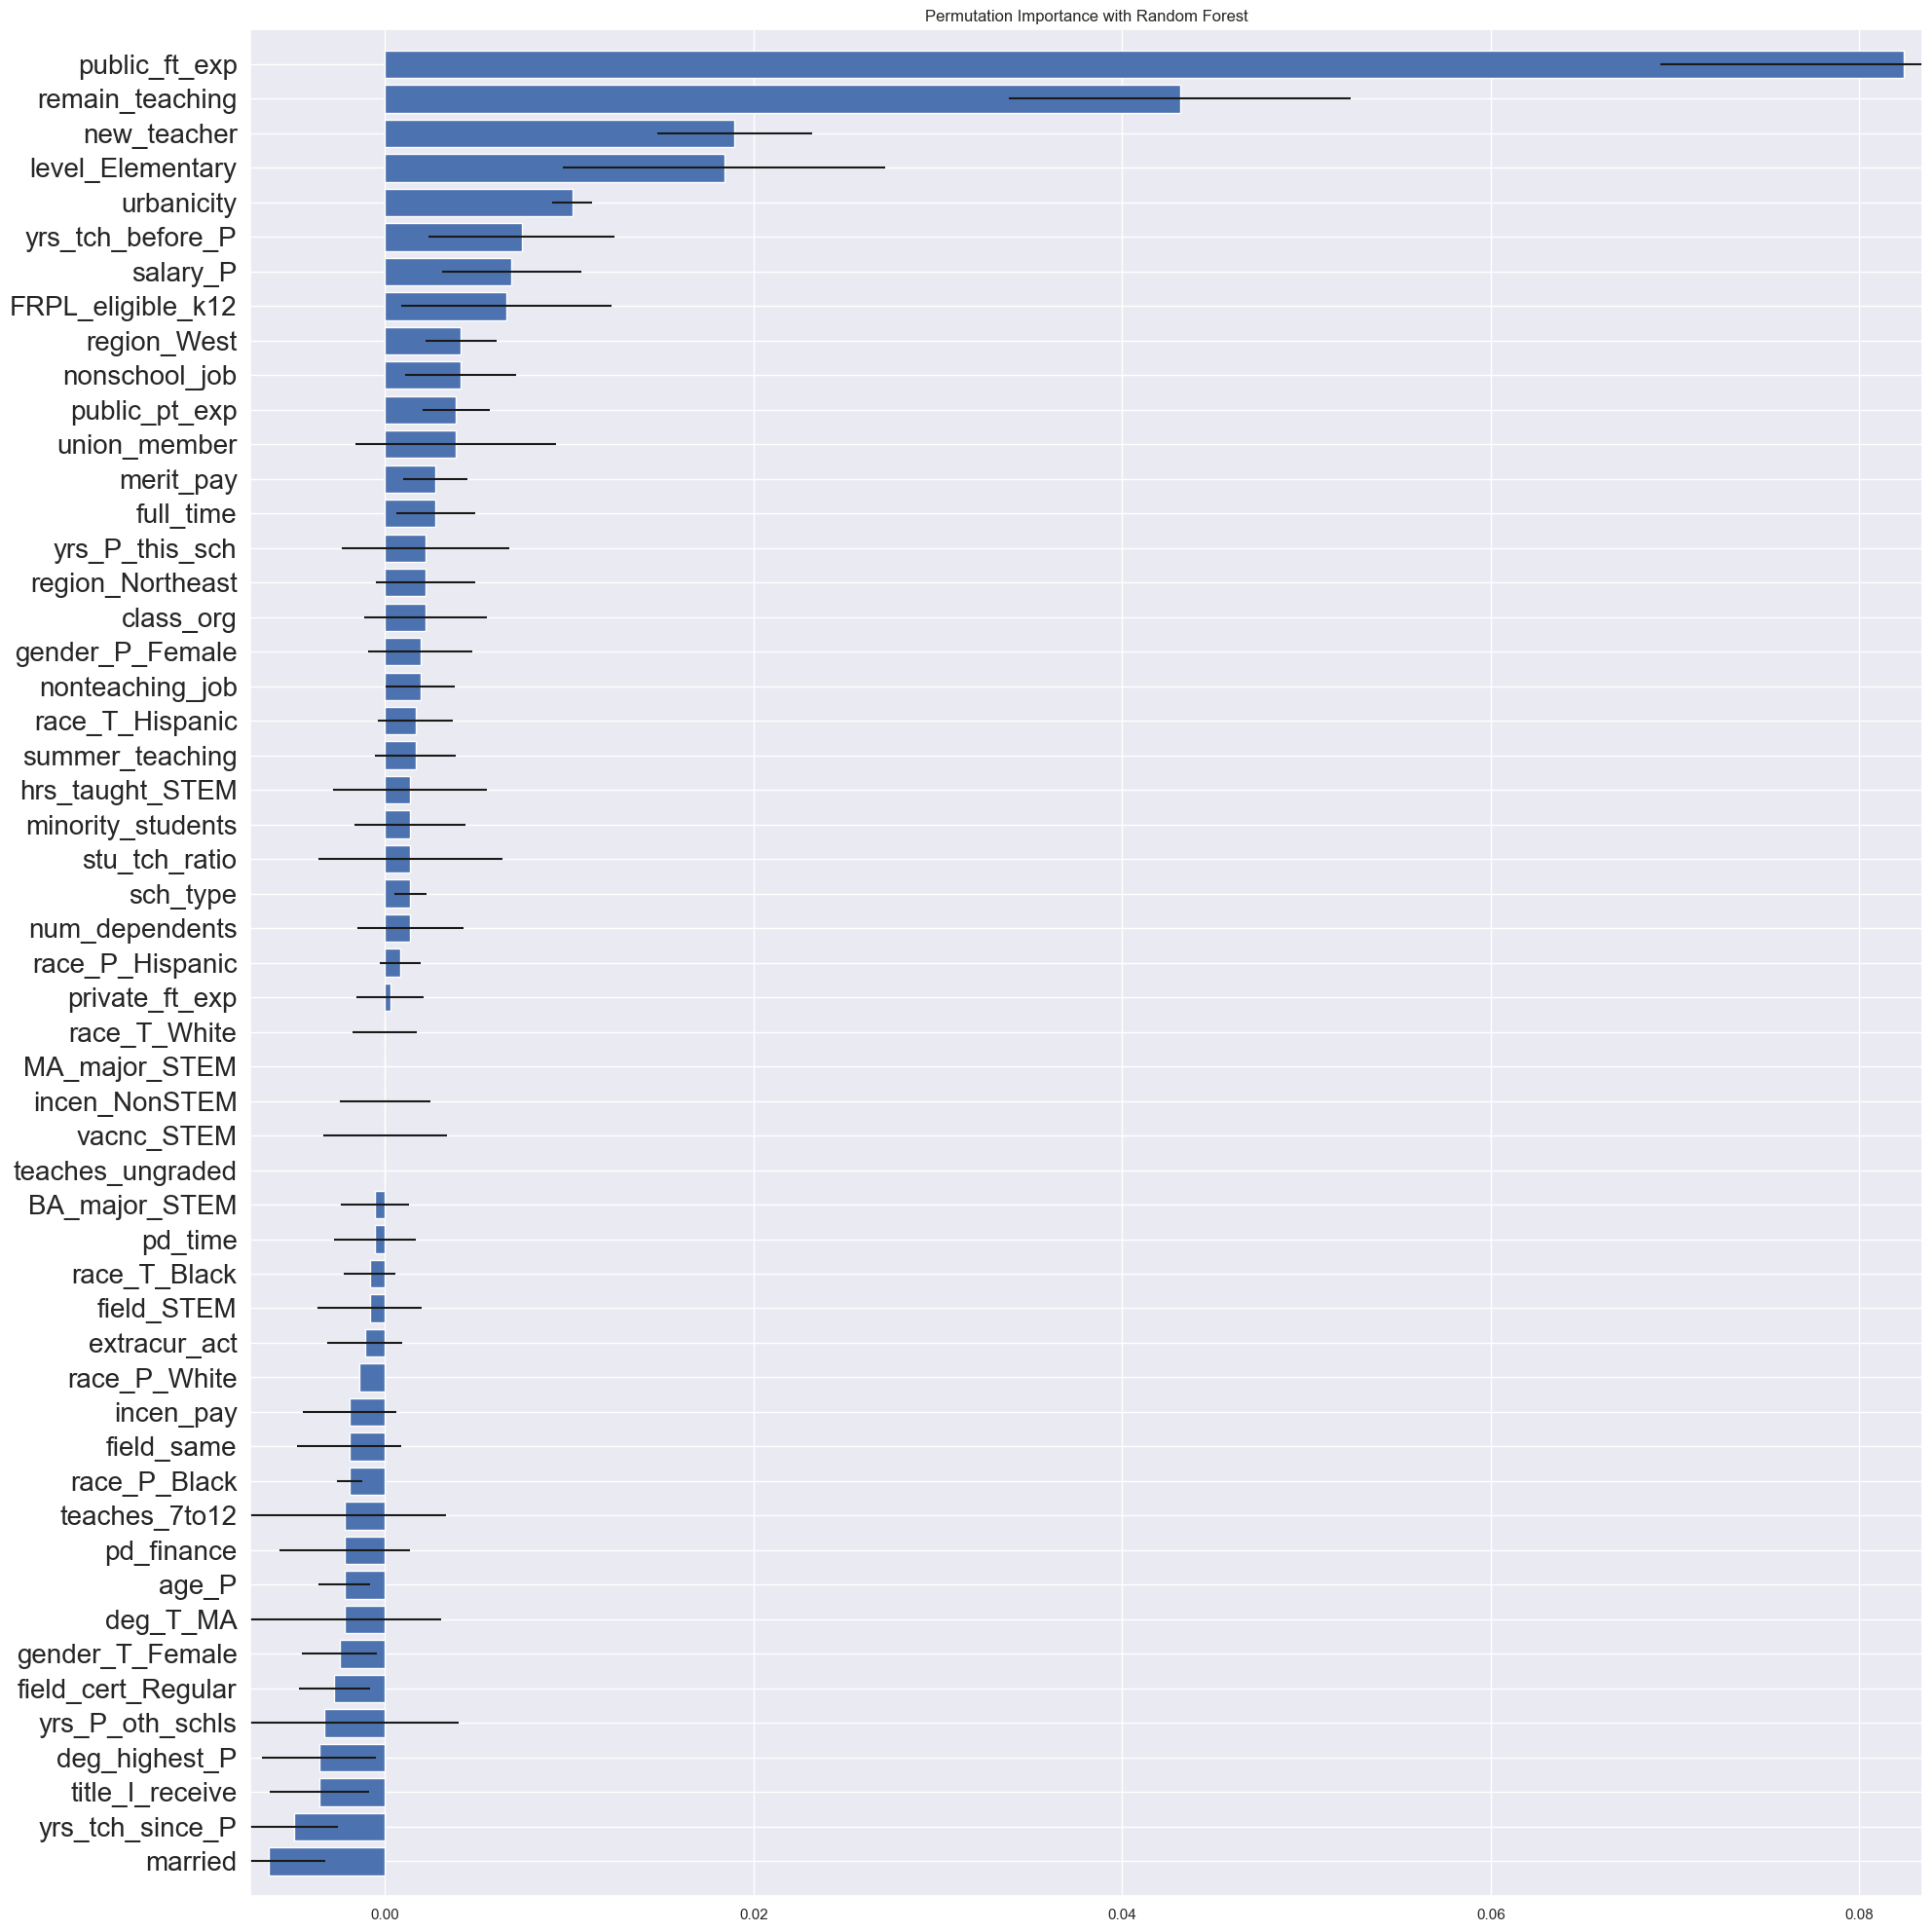

CPU times: total: 4.42 s
Wall time: 5.25 s


In [13]:
%%time
from sklearn.inspection import permutation_importance

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Random Forest")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Random Forest', 
                     'importance': result['importances_mean']})
results = pd.concat([results, temp], ignore_index=True)

### Permutation Importance ###
with Ridge Regression

Train Score: 0.73
Test Score: 0.75


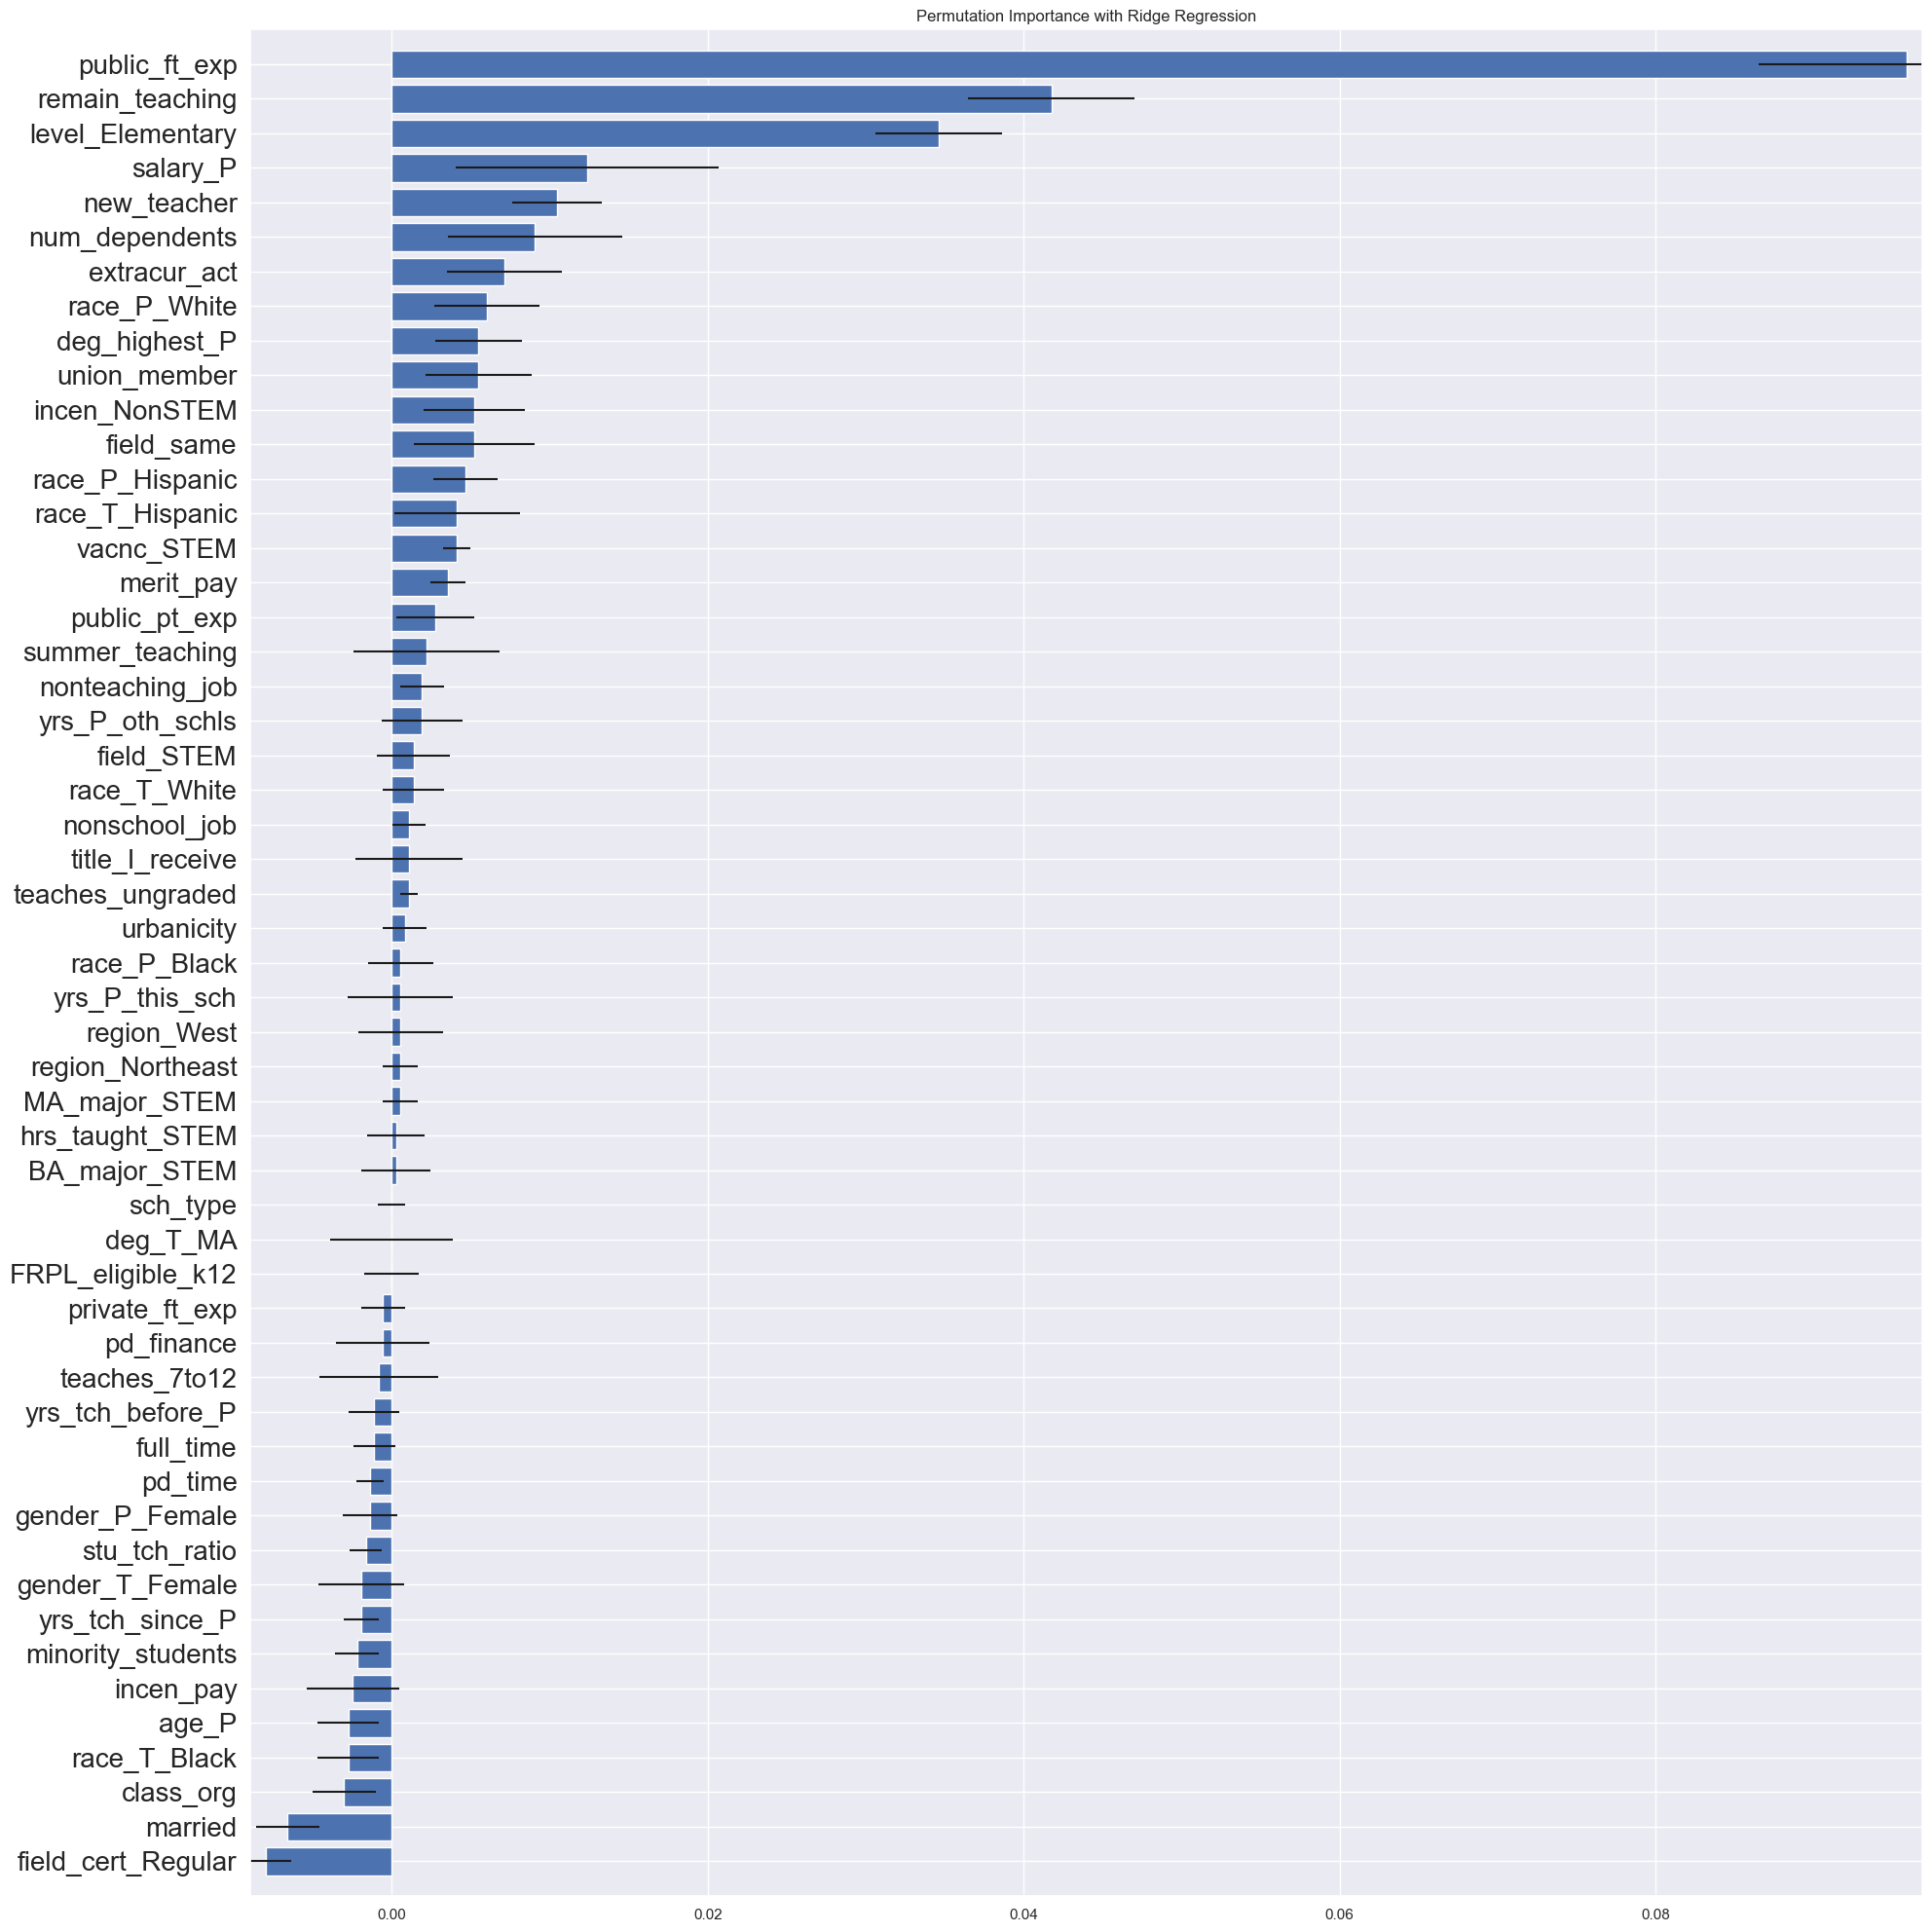

CPU times: total: 828 ms
Wall time: 853 ms


In [14]:
%%time
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

result = permutation_importance(estimator, X=X_test, y=y_test, scoring='accuracy', n_jobs=-1, random_state=random_state)
indices = np.argsort(result['importances_mean'])#[::-1]

plt.figure(figsize=(20,20))
plt.title("Permutation Importance with Ridge Regression")
plt.barh(range(X_train.shape[1]), result['importances_mean'][indices], xerr=result['importances_std'][indices])

plt.yticks(range(X_train.shape[1]), columns[indices], rotation=0, size=20)
plt.ylim([-1, X_train.shape[1]])
plt.xlim([result['importances_mean'].min()-0.001, result['importances_mean'].max()+0.001])

plt.tight_layout()
plt.show()

temp = pd.DataFrame({'feature': columns, 
                     'method': 'Permutation Importance',
                     'model': 'Ridge', 
                     'importance': result['importances_mean']})
results = pd.concat([results, temp], ignore_index=True)

### Recursive Feature Elimination(RFE) ###
with Ridge Regression

In [15]:
%time
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=10, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected: ', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Ridge', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

CPU times: total: 0 ns
Wall time: 0 ns
Train Score: 0.73
Test Score: 0.75
n Selected:  18
Selected Feature:  Index(['num_dependents', 'region_West', 'married', 'summer_teaching',
       'extracur_act', 'union_member', 'BA_major_STEM', 'field_cert_Regular',
       'deg_T_MA', 'remain_teaching', 'public_ft_exp', 'public_pt_exp',
       'field_same', 'new_teacher', 'FRPL_eligible_k12', 'stu_tch_ratio',
       'level_Elementary', 'salary_P'],
      dtype='object')


### Recursive Feature Elimination(RFE) ###
with Random Forest

In [16]:
%time
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

rfe = RFECV(estimator, step=1, cv=5, n_jobs=-1)
sel = rfe.fit(X_train, y_train)
support = sel.support_
n_sel = sel.n_features_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'RFE',
                     'model': 'Random Forest', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

CPU times: total: 0 ns
Wall time: 0 ns
Train Score: 1.00
Test Score: 0.76
n Selected: 49
Selected Feature:  Index(['vacnc_STEM', 'num_dependents', 'region_Northeast', 'region_West',
       'married', 'race_T_White', 'gender_T_Female', 'summer_teaching',
       'nonteaching_job', 'nonschool_job', 'extracur_act', 'merit_pay',
       'union_member', 'BA_major_STEM', 'field_cert_Regular', 'deg_T_MA',
       'pd_time', 'pd_finance', 'remain_teaching', 'field_STEM',
       'hrs_taught_STEM', 'public_ft_exp', 'public_pt_exp', 'private_ft_exp',
       'class_org', 'field_same', 'full_time', 'teaches_7to12', 'new_teacher',
       'minority_students', 'FRPL_eligible_k12', 'stu_tch_ratio', 'sch_type',
       'level_Elementary', 'urbanicity', 'title_I_receive', 'age_P',
       'salary_P', 'yrs_P_this_sch', 'yrs_P_oth_schls', 'yrs_tch_before_P',
       'yrs_tch_since_P', 'deg_highest_P', 'race_P_Black', 'race_P_White',
       'race_P_Hispanic', 'gender_P_Female', 'incen_pay', 'incen_NonSTEM'],
    

### Sequential Feature Selection(SFS) ###
with KNN

In [17]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier

estimator = KNeighborsClassifier(n_neighbors=3)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'KNN', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.82
Test Score: 0.65
n Selected: 26
Selected Feature:  Index(['num_dependents', 'region_Northeast', 'region_West', 'race_T_Hispanic',
       'nonteaching_job', 'nonschool_job', 'merit_pay', 'union_member',
       'MA_major_STEM', 'field_cert_Regular', 'pd_time', 'remain_teaching',
       'field_STEM', 'hrs_taught_STEM', 'public_ft_exp', 'public_pt_exp',
       'field_same', 'full_time', 'teaches_ungraded', 'teaches_7to12',
       'new_teacher', 'stu_tch_ratio', 'sch_type', 'level_Elementary',
       'race_P_Black', 'race_P_Hispanic'],
      dtype='object')


### Sequential Feature Selection(SFS) ###
with Ridge Regression

In [18]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression(penalty='l2', solver='liblinear', C=0.1, random_state=random_state)
estimator.fit(X_train, y_train)
print("Train Score: {:0.2f}".format(estimator.score(X_train, y_train)))
print("Test Score: {:0.2f}".format(estimator.score(X_test, y_test)))

sfs = SequentialFeatureSelector(estimator, n_jobs=-1, n_features_to_select='auto', tol=None)
sfs.fit(X_train, y_train)

support = sfs.get_support()
n_sel = sfs.n_features_to_select_

print('n Selected:', n_sel)
print('Selected Feature: ', columns[support])

temp = pd.DataFrame({'feature': columns, 
                     'method': 'SFS',
                     'model': 'Ridge', 
                     'importance': [1 if ft in columns[support] else 0 for ft in columns]})
results = pd.concat([results, temp], ignore_index=True)

Train Score: 0.73
Test Score: 0.75
n Selected: 26
Selected Feature:  Index(['region_Northeast', 'race_T_Black', 'race_T_Hispanic',
       'gender_T_Female', 'BA_major_STEM', 'MA_major_STEM',
       'field_cert_Regular', 'pd_time', 'remain_teaching', 'hrs_taught_STEM',
       'public_ft_exp', 'public_pt_exp', 'private_ft_exp', 'class_org',
       'field_same', 'teaches_7to12', 'minority_students', 'stu_tch_ratio',
       'sch_type', 'level_Elementary', 'age_P', 'yrs_P_this_sch',
       'yrs_tch_before_P', 'race_P_White', 'race_P_Hispanic', 'incen_pay'],
      dtype='object')


### Number of Feature Selected ###

In [19]:
results[results['method'] == 'Feature Importance']['importance'].describe()

count    53.000000
mean      0.018868
std       0.021216
min       0.001225
25%       0.007678
50%       0.011355
75%       0.023877
max       0.129917
Name: importance, dtype: float64

In [20]:
results['selected'] = results['importance'].apply(lambda x: 1 if x > 0 else 0)

th_quantile=0.5
th_rf = results[results['method'] == 'Feature Importance']['importance'].quantile(th_quantile)
print('Threshold for Random Forest Feature Importance is {:0.4f} at {:0.0f}th percentile'.format(th_rf, th_quantile*100))
results['selected'] = results.apply(lambda x: 0 if ((x.method == 'Feature Importance') & (x.importance < th_rf))
                                                 else x.selected, axis=1)
              
results['Method'] = results.apply(lambda x: 'Variance Threshold' if x.method == 'Variance Threshold'
                                                                 else str(x.method) + " - " + str(x.model), axis=1)

Threshold for Random Forest Feature Importance is 0.0114 at 50th percentile


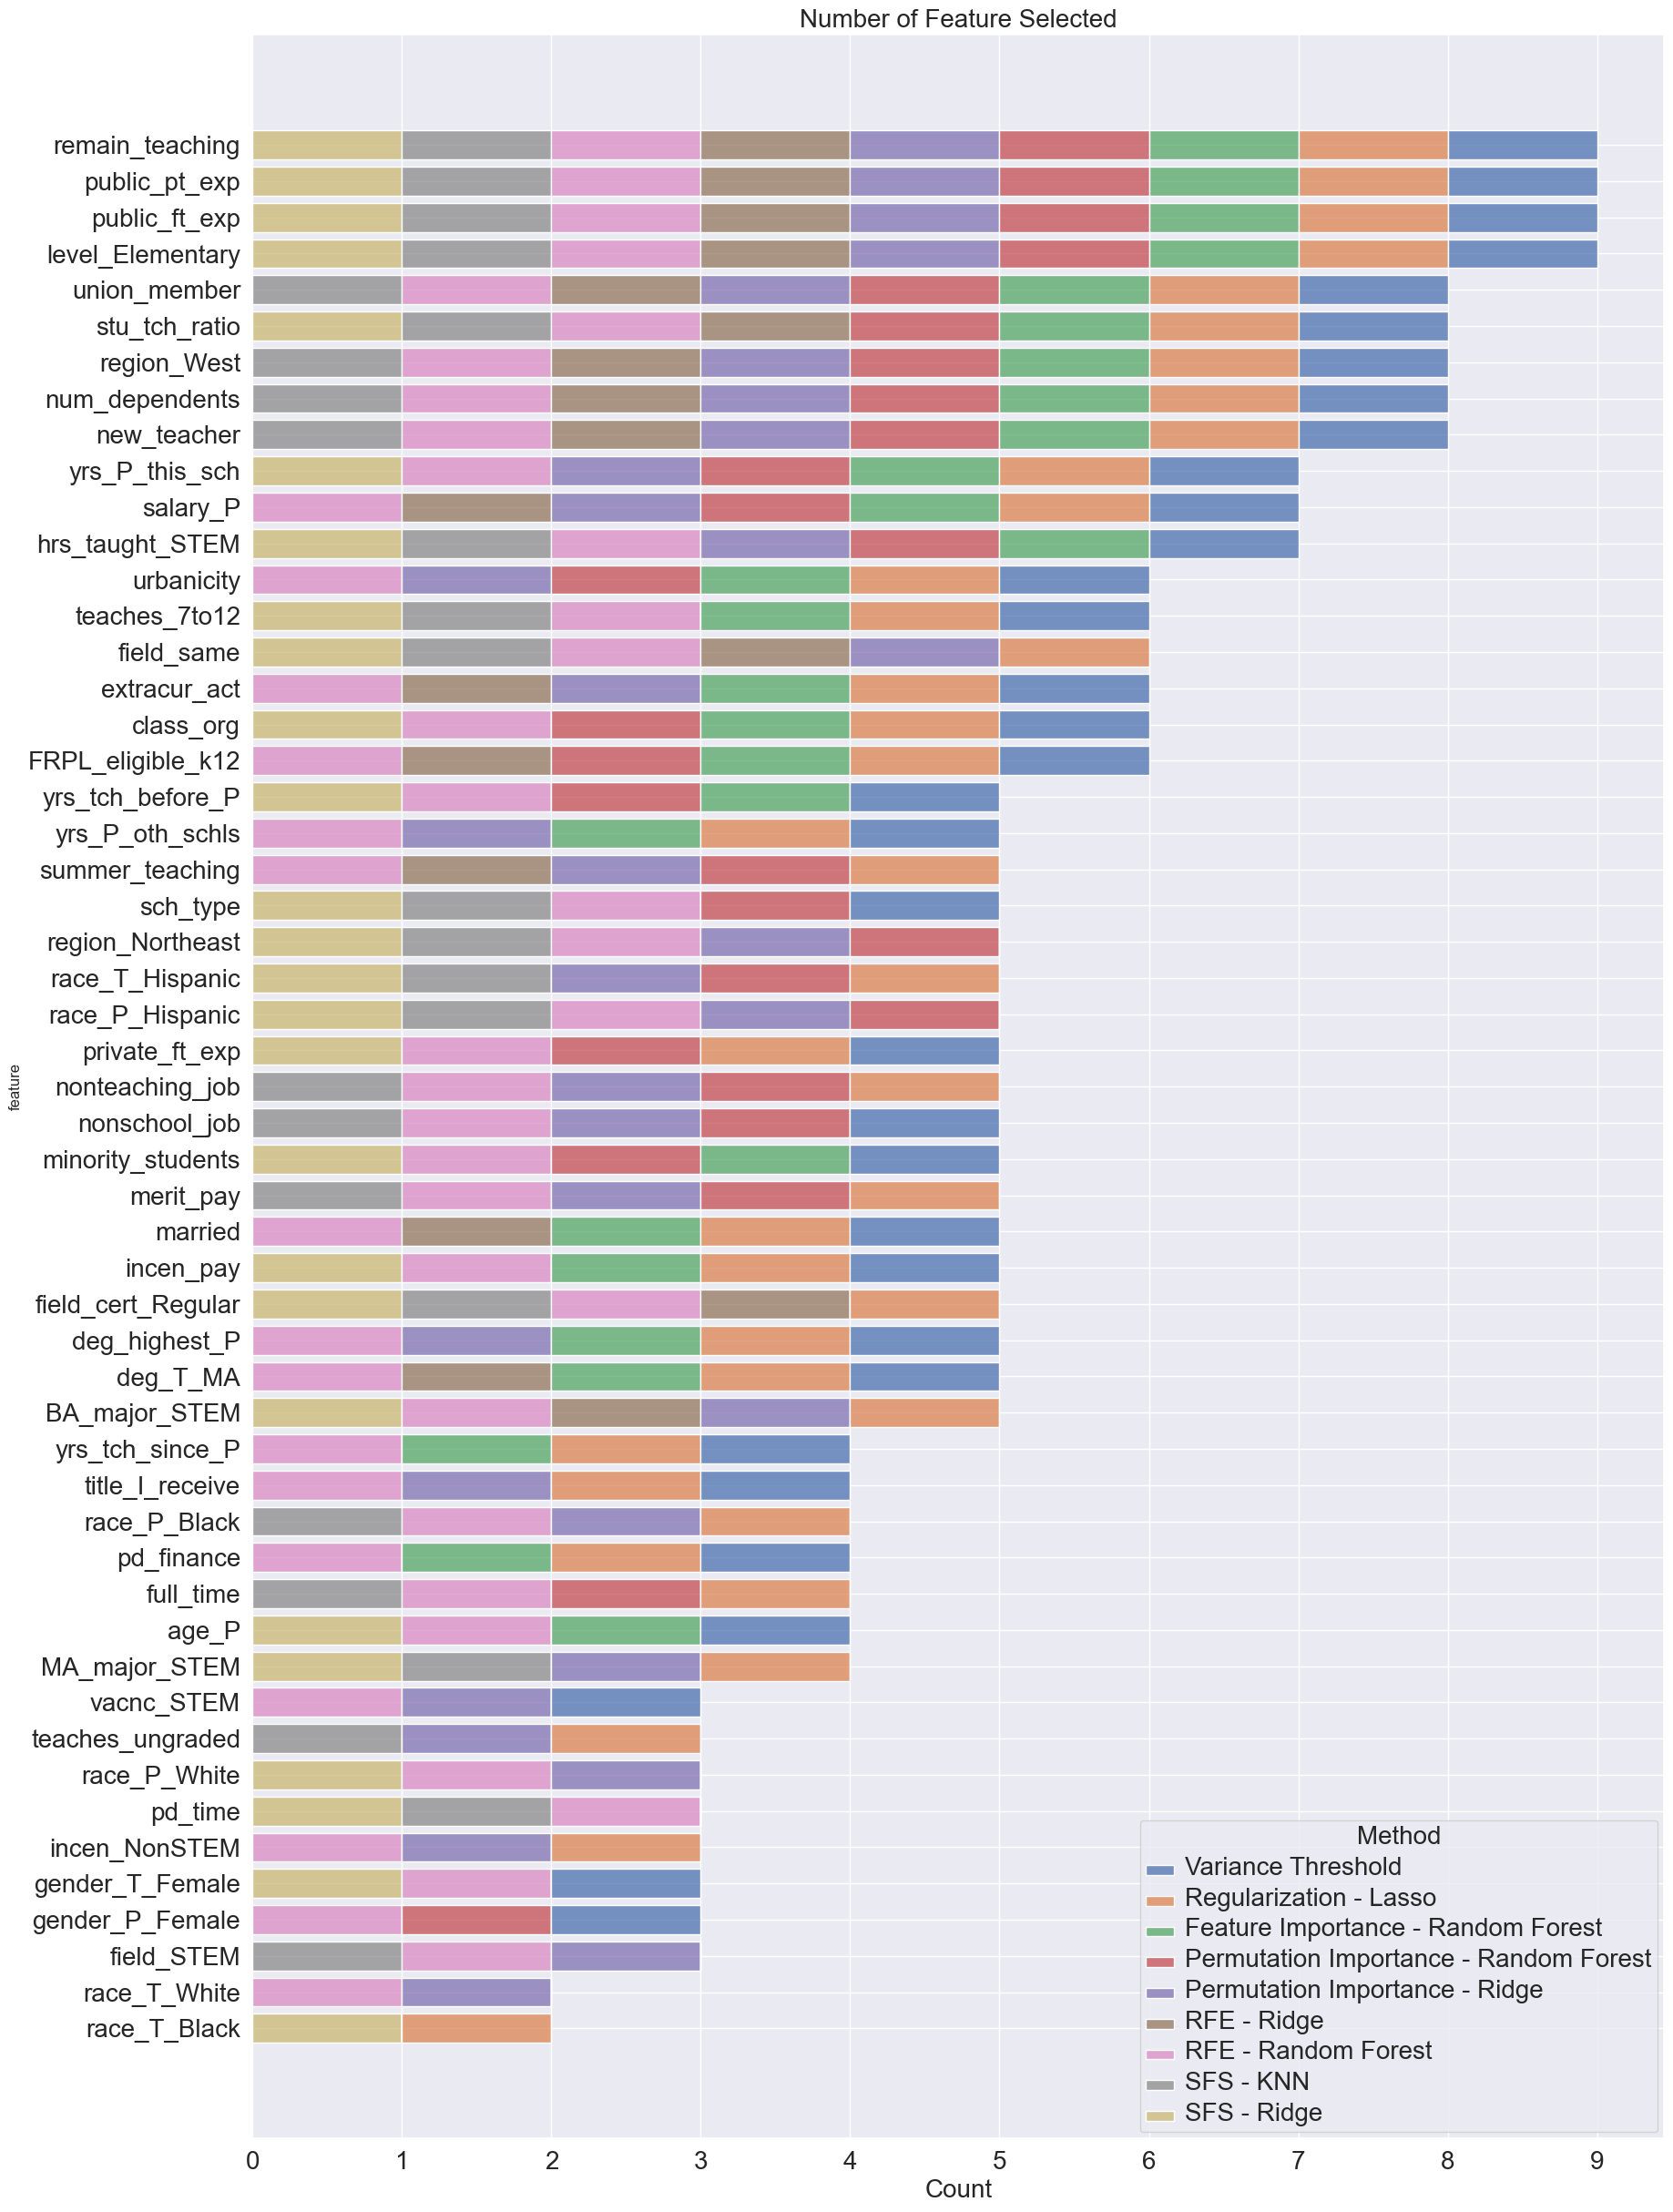

In [21]:
sns.set(rc={'figure.figsize':(20,30)})

data = results[results['selected'] == 1].copy()
data['counts']=data.groupby('feature').transform(lambda x: x.sum())['selected']
data = data.sort_values(by=['counts', 'feature'], ascending=False)

g = sns.histplot(data=data, y='feature', hue='Method', multiple='stack', shrink=0.8, legend=True)
plt.title('Number of Feature Selected', size=20)
plt.xlabel('Count', size=20)
plt.xticks(range(len(data['Method'].unique())+1), list(range(len(data['Method'].unique())+1)), size=20)
plt.yticks(range(len(data.feature.unique())), data.feature.unique(), size=20)
# plt.legend(fontsize=20)
plt.setp(g.get_legend().get_texts(), fontsize='20')
plt.setp(g.get_legend().get_title(), fontsize='20') 
plt.show()

In [22]:
data2 = data.groupby(['feature'], as_index=False).agg({'counts': 'count'})
data2 = data2.sort_values(by=['counts', 'feature'], ascending=False)
data2

,feature,counts
38,remain_teaching,9
29,public_pt_exp,9
28,public_ft_exp,9
17,level_Elementary,9
46,union_member,8
41,stu_tch_ratio,8
37,region_West,8
24,num_dependents,8
21,new_teacher,8
50,yrs_P_this_sch,7


### Evaluating sets of features ###
with models: Lasso, Ridge, Random Forest, Gradient Boosting, KNN

In [23]:
def model_report_1(estimator, name):
    df_report = pd.DataFrame()
    
    for count in range(data['counts'].min(), data['counts'].max()+1):
        features = data[data['counts'] >= count]['feature'].unique().tolist()
        index = np.argwhere(np.isin(columns, features))
        X_train2 = X_train[:, index.flatten()]
        X_test2 = X_test[:, index.flatten()]
       
        estimator.fit(X_train2, y_train)
        y_pred = estimator.predict(X_test2)
        temp = {'model': name,
                'n Selected': int(index.shape[0]),
                'type': 'by counts',
                'Counts': count,
                'Method': np.nan,
                'Train Accuracy': estimator.score(X_train2, y_train),
                'Test Accuracy': estimator.score(X_test2, y_test),
                'MCC': matthews_corrcoef(y_test, y_pred),
                'F1': f1_score(y_test, y_pred, average='weighted'),
                'features': features,
                'index': index}
        df_report = pd.concat([df_report, pd.DataFrame([temp])], ignore_index=True)
    return df_report

def model_report_2(estimator, name):
    df_report = pd.DataFrame()
    
    for method in data['Method'].unique():
        features = data[data['Method'] == method]['feature'].unique().tolist()
        index = np.argwhere(np.isin(columns, features))
        X_train2 = X_train[:, index.flatten()]
        X_test2 = X_test[:, index.flatten()]
       
        estimator.fit(X_train2, y_train)
        y_pred = estimator.predict(X_test2)
        temp = {'model': name,
                'n Selected': int(index.shape[0]),
                'type': 'by methods',
                'Method': method,
                'Counts': 'n/a',
                'Train Accuracy': estimator.score(X_train2, y_train),
                'Test Accuracy': estimator.score(X_test2, y_test),
                'MCC': matthews_corrcoef(y_test, y_pred),
                'F1': f1_score(y_test, y_pred, average='weighted'),
                'features': features,
                'index': index}
        df_report = pd.concat([df_report, pd.DataFrame([temp])], ignore_index=True)
    return df_report

Lasso

In [24]:
report = pd.DataFrame()

estimator = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=random_state)

temp = model_report_1(estimator, 'Lasso')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'Lasso')
report = pd.concat([report, temp], ignore_index=True)

Ridge

In [25]:
estimator = LogisticRegression(penalty='l2', solver='liblinear', C=0.1, random_state=random_state)

temp = model_report_1(estimator, 'Ridge')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'Ridge')
report = pd.concat([report, temp], ignore_index=True)

Random Forest

In [26]:
estimator = RandomForestClassifier(random_state=random_state, n_jobs=-1)

temp = model_report_1(estimator, 'Random Forest')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'Random Forest')
report = pd.concat([report, temp], ignore_index=True)

Grandient Boosting

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
estimator = GradientBoostingClassifier(n_estimators=100, random_state=random_state)

temp = model_report_1(estimator, 'Gradient Boosting')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'Grandient Boosting')
report = pd.concat([report, temp], ignore_index=True)

KNN

In [28]:
estimator = KNeighborsClassifier(n_neighbors=3)

temp = model_report_1(estimator, 'KNN')
report = pd.concat([report, temp], ignore_index=True)
temp = model_report_2(estimator, 'KNN')
report = pd.concat([report, temp], ignore_index=True)

In [29]:
report2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC']:
    temp = report[['model', 'n Selected', 'type', 'Method'] + [col]].copy()
    temp.loc[:, 'Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    report2 = pd.concat([report2, temp], ignore_index=True)
report2=report2.astype({'n Selected': 'int32'})

**Evaluating Feature Set by Counts Selected**

In [30]:
for count in data2['counts'].unique():
    print('n Selected by {} methods: {}'.format(count, (data2[data2['counts'] >= count].shape[0])))

n Selected by 9 methods: 4
n Selected by 8 methods: 9
n Selected by 7 methods: 12
n Selected by 6 methods: 18
n Selected by 5 methods: 36
n Selected by 4 methods: 43
n Selected by 3 methods: 51
n Selected by 2 methods: 53


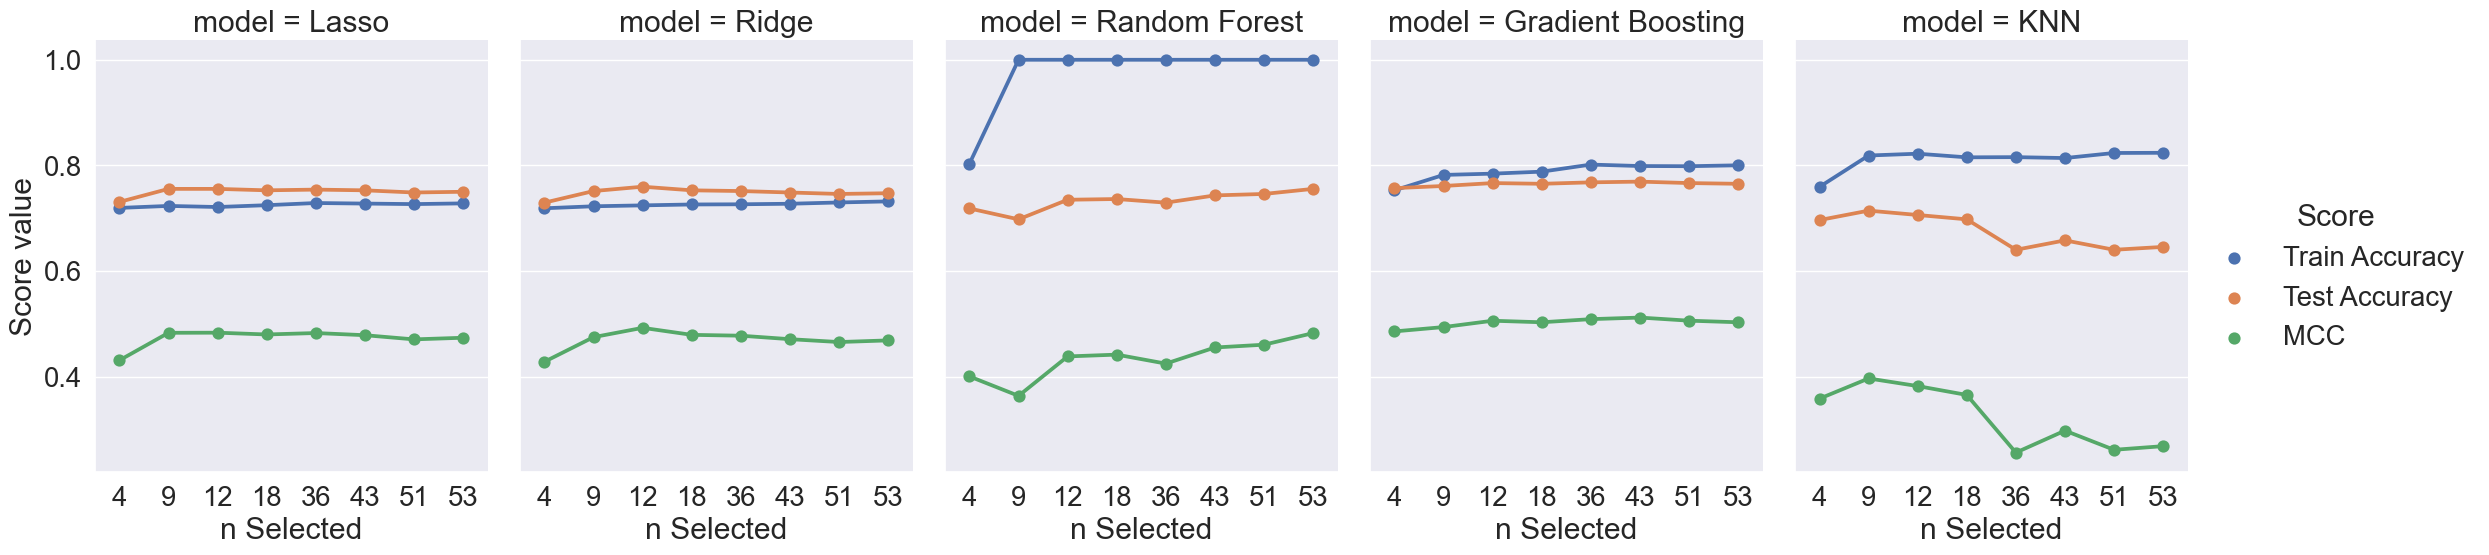

In [31]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="model",
                capsize=.2, palette="deep", height=6, aspect=.75,
                kind="point", data=report2[report2['type']=='by counts'])
# g.despine(left=True)
plt.show()

**Evaluating Feature Set by Selection Methods**

In [32]:
report2[report2['type']=='by methods'].groupby(['Method'], as_index=False).agg({'n Selected': 'max'}).sort_values(by=['n Selected'])

,Method,n Selected
4,RFE - Ridge,18
6,SFS - KNN,26
7,SFS - Ridge,26
0,Feature Importance - Random Forest,27
1,Permutation Importance - Random Forest,28
2,Permutation Importance - Ridge,33
8,Variance Threshold,34
5,Regularization - Lasso,38
3,RFE - Random Forest,49


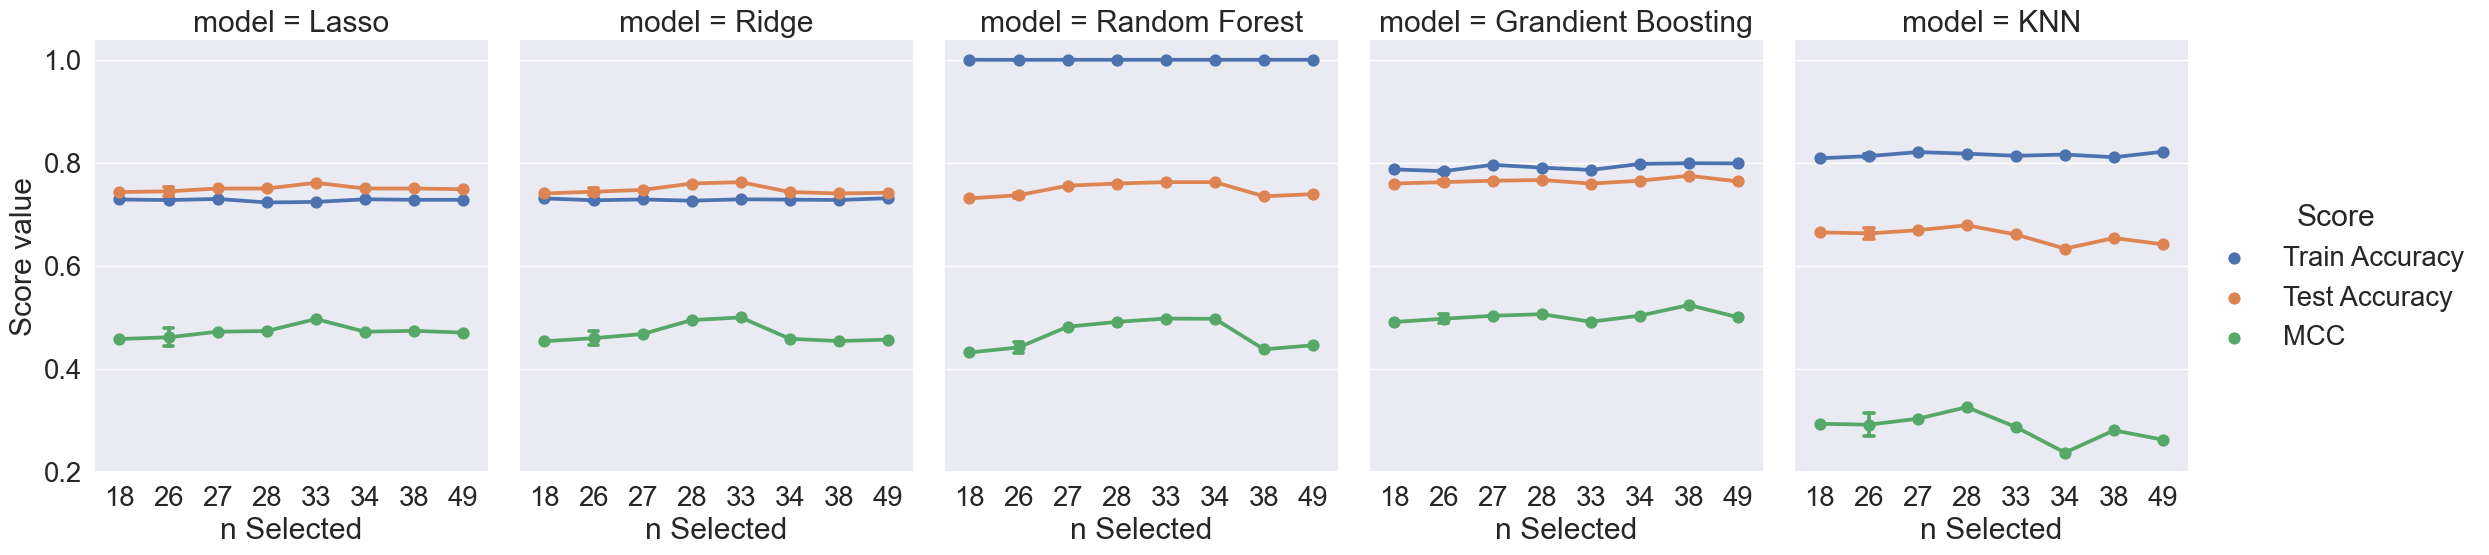

In [33]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="model",
                capsize=.2, palette="deep", height=6, aspect=.75,
                kind="point", data=report2[report2['type']=='by methods'])
g.despine(left=True)
plt.show()

In [34]:
report.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(10)

,model,n Selected,type,Counts,Method,Train Accuracy,Test Accuracy,MCC,F1,features,index
60,Grandient Boosting,38,by methods,n/a,Regularization - Lasso,0.799107,0.774725,0.523722,0.769392,"[remain_teaching, public_pt_exp, public_ft_exp...","[[1], [3], [4], [6], [7], [9], [10], [12], [13..."
53,Gradient Boosting,43,by counts,4,NaN,0.798764,0.769231,0.511779,0.764017,"[remain_teaching, public_pt_exp, public_ft_exp...","[[1], [2], [3], [4], [7], [9], [10], [11], [12..."
54,Gradient Boosting,36,by counts,5,NaN,0.801511,0.767857,0.508765,0.762487,"[remain_teaching, public_pt_exp, public_ft_exp...","[[1], [2], [3], [4], [7], [9], [10], [11], [12..."
52,Gradient Boosting,51,by counts,3,NaN,0.798420,0.766484,0.505873,0.761456,"[remain_teaching, public_pt_exp, public_ft_exp...","[[0], [1], [2], [3], [4], [7], [8], [9], [10],..."
62,Grandient Boosting,28,by methods,n/a,Permutation Importance - Random Forest,0.790522,0.766484,0.505873,0.761456,"[remain_teaching, public_pt_exp, public_ft_exp...","[[1], [2], [3], [7], [9], [10], [11], [13], [1..."
66,Grandient Boosting,26,by methods,n/a,SFS - KNN,0.786401,0.766484,0.505802,0.761208,"[remain_teaching, public_pt_exp, public_ft_exp...","[[1], [2], [3], [7], [10], [11], [13], [14], [..."
56,Gradient Boosting,12,by counts,7,NaN,0.784341,0.766484,0.505750,0.760955,"[remain_teaching, public_pt_exp, public_ft_exp...","[[1], [3], [14], [21], [23], [24], [25], [32],..."
59,Grandient Boosting,34,by methods,n/a,Variance Threshold,0.797734,0.765110,0.503044,0.760418,"[remain_teaching, public_pt_exp, public_ft_exp...","[[0], [1], [3], [4], [8], [11], [12], [14], [1..."
51,Gradient Boosting,53,by counts,2,NaN,0.800137,0.765110,0.502850,0.759928,"[remain_teaching, public_pt_exp, public_ft_exp...","[[0], [1], [2], [3], [4], [5], [6], [7], [8], ..."
55,Gradient Boosting,18,by counts,6,NaN,0.788118,0.765110,0.502850,0.759928,"[remain_teaching, public_pt_exp, public_ft_exp...","[[1], [3], [12], [14], [21], [23], [24], [25],..."


In [35]:
report_mean_score = report[report['type']=='by methods'].groupby('Method', as_index=False).agg({'Test Accuracy': 'mean', 'MCC': 'mean'})
report_mean_score

,Method,Test Accuracy,MCC
0,Feature Importance - Random Forest,0.737363,0.445278
1,Permutation Importance - Random Forest,0.742857,0.457963
2,Permutation Importance - Ridge,0.741209,0.454313
3,RFE - Random Forest,0.726923,0.426785
4,RFE - Ridge,0.727747,0.425309
5,Regularization - Lasso,0.730769,0.433805
6,SFS - KNN,0.736813,0.444501
7,SFS - Ridge,0.723352,0.415430
8,Variance Threshold,0.730769,0.433381


In [36]:
report.to_csv('../data/data_clean/Task2_Feature_Selection_v2_Report.csv', index=False)

In [37]:
results.to_csv('../data/data_clean/Task2_Feature_Selection_v2_Results.csv', index=False)